In [1]:
import pandas 
import numpy as np
import os
import re
import operator
import math
import h5py
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from constants import *
from data import *
from encoders import *
from decoders import *
from solver import *
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as torchmodels

/home/davech2y/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
from utils import *

train_size = 100
test_size = 10
batch_size = 10
attention = True
pretrained = "resnet"
encoder_path = "encoder_coco_resnet_attention_trs100_vs10_ts0_e30_lr0.001000_wd0.000000_bs10_vocal937_beam1.pth"
decoder_path = "decoder_coco_resnet_attention_trs100_vs10_ts0_e30_lr0.001000_wd0.000000_bs10_vocal937_beam1.pth"
coco = COCO(
    # for training
    pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014.caption.csv"), 
    pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_val2014.caption.csv"),
    pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_test2014.caption.csv"),
    [train_size, 0, test_size]
)
dict_idx2word = coco.dict_idx2word
corpus = coco.corpus["test"]
test_ds = COCOCaptionDataset(
    "/mnt/raid/davech2y/COCO_2014/preprocessed/test_index.json", 
    coco.transformed_data['test'], 
    database="data/test_feature_{}.hdf5".format(pretrained)
)
test_dl = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
print("initializing models...")
print()
encoder = torch.load(os.path.join("models", encoder_path)).cuda()
decoder = torch.load(os.path.join("models", decoder_path)).cuda()
print("evaluating...")
print()
encoder.eval()
decoder.eval()
beam_size = [3, 5, 7]
candidates = {i:{} for i in beam_size}
outputs = {i:{} for i in beam_size}
bleu = {i:{} for i in beam_size}
cider = {i:{} for i in beam_size}
rouge = {i:{} for i in beam_size}
for _, (model_ids, visuals, captions, cap_lengths) in enumerate(test_dl):
    visual_inputs = Variable(visuals, requires_grad=False).cuda()
    caption_inputs = Variable(captions[:, :-1], requires_grad=False).cuda()
    cap_lengths = Variable(cap_lengths, requires_grad=False).cuda()
    visual_contexts = encoder(visual_inputs)
    max_length = int(cap_lengths[0].item()) + 10
    for bs in beam_size:
        if attention:
            outputs[bs] = decoder.beam_search(visual_contexts, caption_inputs, bs, max_length)
            outputs[bs] = decode_attention_outputs(outputs[bs], None, dict_idx2word, "val")
        else:
            outputs[bs] = decoder.beam_search(visual_contexts, bs, max_length)
            outputs[bs] = decode_outputs(outputs, None, dict_idx2word, "val")
        for model_id, output in zip(model_ids, outputs[bs]):
            if model_id not in candidates[bs].keys():
                candidates[bs][model_id] = [output]
            else:
                candidates[bs][model_id].append(output)

initializing models...

evaluating...



In [52]:
import capeval.bleu.bleu as capbleu
import capeval.cider.cider as capcider
import capeval.meteor.meteor as capmeteor
import capeval.rouge.rouge as caprouge

bleu = capbleu.Bleu(4).compute_score(corpus, candidates[3])

In [55]:
bleu[1]

[[0.5366925751109899,
  0.49805493606340595,
  0.4166666665972223,
  0.4971329536752872,
  0.46002220723799137,
  0.3749999999765626,
  0.636363636247934,
  0.27272727270247943,
  0.8333333331944446,
  0.3124999999804688],
 [0.21187067367915693,
  0.21325438302191876,
  0.27524094123467413,
  0.2358108650294949,
  0.19615412824451478,
  0.15811388299820756,
  0.43693144867122347,
  0.16514456475319042,
  0.6154574547917563,
  0.14433756728808472],
 [1.6044154275521945e-06,
  1.6647819888968582e-06,
  1.964002439338421e-06,
  1.922759120544058e-06,
  1.5240570801075004e-06,
  1.2132137515201732e-06,
  2.7681823800578e-06,
  1.4470893700930521e-06,
  0.33583969304830574,
  1.1416778509143985e-06],
 [4.5329318833656714e-09,
  4.790437744888919e-09,
  5.386366367864088e-09,
  5.706135913544768e-09,
  4.3615664704852085e-09,
  3.4234749556315017e-09,
  7.175852913353726e-09,
  4.411629358851744e-09,
  4.529376169980084e-05,
  3.2709344706502825e-09]]

In [35]:
for _, (model_ids, visuals, captions, cap_lengths) in enumerate(test_dl):
    break

In [37]:
for model_id, y in zip(model_ids, ):
    print(model_id, y)

10256 1
24212 1
36121 1
3690 1
10256 1
4391 1
34957 1
4391 1
34957 1
3690 1


In [36]:
coco.original_csv["val"]

,image_id,caption,file_name
0,119896,a dog on the floor curled next to several pair...,COCO_train2014_000000458478.jpg
1,114145,mail is sitting on top of a microwave,COCO_train2014_000000167395.jpg
2,121816,cupcakes have crumbs and teddy bears on top of...,COCO_train2014_000000298914.jpg
3,92406,a man is in the air on a skateboard,COCO_train2014_000000201929.jpg
4,105604,some kind of animals next to a brick wall,COCO_train2014_000000443308.jpg
5,47174,a man showing a woman how to properly throw a ...,COCO_train2014_000000308722.jpg
6,105608,a person wearing a fairy outfit walking in a f...,COCO_train2014_000000237222.jpg
7,58930,a plate with a bunch of sliced fruit on it,COCO_train2014_000000091530.jpg
8,49338,a close up of two sandwiches and a bowl of sauce,COCO_train2014_000000500060.jpg
9,76057,a person standing on a grass covered field in ...,COCO_train2014_000000033429.jpg


In [37]:
coco.transformed_data["val"]

,image_id,caption,file_name
0,119896,"[1, 3, 19, 5, 6, 46, 36, 11, 8, 76, 47, 4, 25, 2]",COCO_train2014_000000458478.jpg
1,114145,"[1, 37, 12, 20, 5, 16, 4, 3, 21, 2]",COCO_train2014_000000167395.jpg
2,121816,"[1, 38, 77, 78, 10, 48, 17, 5, 16, 4, 49, 79, 2]",COCO_train2014_000000298914.jpg
3,92406,"[1, 3, 13, 12, 7, 6, 26, 5, 3, 80, 2]",COCO_train2014_000000201929.jpg
4,105604,"[1, 27, 81, 4, 82, 11, 8, 3, 50, 51, 2]",COCO_train2014_000000443308.jpg
5,47174,"[1, 3, 13, 83, 3, 22, 52, 8, 84, 85, 3, 39, 2]",COCO_train2014_000000308722.jpg
6,105608,"[1, 3, 28, 53, 3, 86, 87, 88, 7, 3, 14, 2]",COCO_train2014_000000237222.jpg
7,58930,"[1, 3, 54, 9, 3, 55, 4, 89, 90, 5, 29, 2]",COCO_train2014_000000091530.jpg
8,49338,"[1, 3, 56, 23, 4, 15, 30, 10, 3, 18, 4, 91, 2]",COCO_train2014_000000500060.jpg
9,76057,"[1, 3, 28, 40, 5, 3, 92, 93, 14, 7, 41, 94, 57...",COCO_train2014_000000033429.jpg


In [38]:
coco.preprocessed_data["val"]

,image_id,caption,file_name
0,119896,<START> a dog on the floor curled next to seve...,COCO_train2014_000000458478.jpg
1,114145,<START> mail is sitting on top of a microwave ...,COCO_train2014_000000167395.jpg
2,121816,<START> cupcakes have crumbs and teddy bears o...,COCO_train2014_000000298914.jpg
3,92406,<START> a man is in the air on a skateboard <END>,COCO_train2014_000000201929.jpg
4,105604,<START> some kind of animals next to a brick w...,COCO_train2014_000000443308.jpg
5,47174,<START> a man showing a woman how to properly ...,COCO_train2014_000000308722.jpg
6,105608,<START> a person wearing a fairy outfit walkin...,COCO_train2014_000000237222.jpg
7,58930,<START> a plate with a bunch of sliced fruit o...,COCO_train2014_000000091530.jpg
8,49338,<START> a close up of two sandwiches and a bow...,COCO_train2014_000000500060.jpg
9,76057,<START> a person standing on a grass covered f...,COCO_train2014_000000033429.jpg


In [19]:
index = json.load(open("/mnt/raid/davech2y/COCO_2014/preprocessed/train_index.json", "r"))

In [20]:
dataset = h5py.File("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014_224.hdf5", "r")

In [21]:
temp = dataset["images"][0].reshape(3, 224, 224)

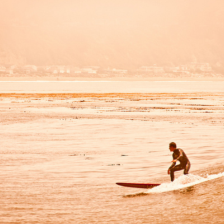

In [22]:
temp = torch.FloatTensor(temp)
temp[0] = temp[0] * 0.229 + 0.485
temp[1] = temp[1] * 0.224 + 0.456
temp[2] = temp[2] * 0.225 + 0.406
torchvision.transforms.ToPILImage()(temp)

In [21]:
df = pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014.caption.csv")
l = df.file_name.values.tolist()

In [23]:
df.caption.values.tolist()[308450]

'an old woman and a middle aged woman sitting on a boat the middle aged woman is holding a stuffed panda bear'

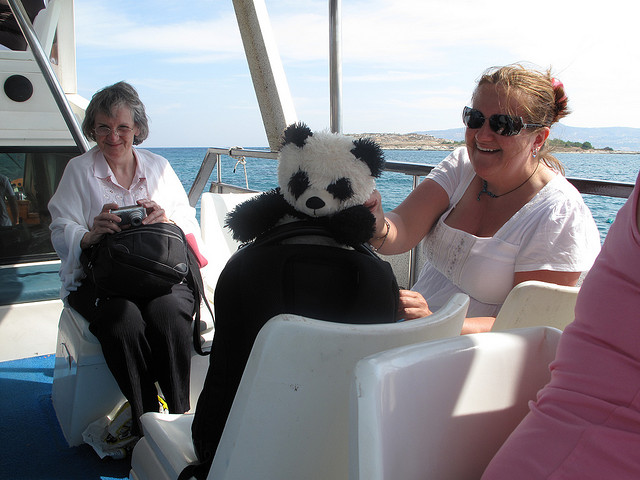

In [24]:
Image.open("/mnt/raid/davech2y/COCO_2014/train2014/{}".format("COCO_train2014_000000289248.jpg"))

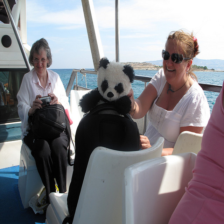

In [34]:
image = Image.open("/mnt/raid/davech2y/COCO_2014/train2014/{}".format(l[414112]))
trans = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.CenterCrop(224),
    transforms.ToTensor()
])
image = trans(image)
image = image.expand(3, image.size(1), image.size(2))
transforms.ToPILImage()(image)

In [257]:
train_size = 100
valid_size = 10
batch_size = 2
coco = COCO(
    pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014.caption.csv"), 
#     pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014.caption.csv"), 
    pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_valid2014.caption.csv"),
    [train_size, valid_size]
)
train_captions = coco.transformed_data['train']
valid_captions = coco.transformed_data['valid']
dict_idx2word = coco.dict_idx2word
dict_word2idx = coco.dict_word2idx
corpus = coco.corpus
train_ds = COCOCaptionDataset(
    None,
    train_captions, 
    database="/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014_224_new.hdf5"
)
valid_ds = COCOCaptionDataset(
    None, 
    valid_captions,
    database="/mnt/raid/davech2y/COCO_2014/preprocessed/coco_valid2014_224_new.hdf5"
#     database="/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014_224_new.hdf5"
)
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
dataloader = {
    'train': train_dl,
    'valid': valid_dl
}

In [239]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.ReLU()
        )
    
    def forward(self, inputs, caption_inputs):
        visual_encoded = self.encoder(inputs)
        outputs = self.decoder(visual_encoded)
        
        return outputs

In [240]:
class AE_skip(nn.Module):
    def __init__(self):
        super(AE_skip, self).__init__()
        self.encoder_1 = nn.Sequential(
            # (3, 224, 224)
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.encoder_2 = nn.Sequential(
            # (8, 112, 112)
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.encoder_3 = nn.Sequential(
            # (16, 56, 56)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.encoder_4 = nn.Sequential(
            # (32, 28, 28)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (64, 14, 14)
        )
        self.encoder_5 = nn.Sequential( 
            # (64, 14, 14)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # (128, 7, 7)
        )

        self.decoder_1 = nn.Sequential(
            # (128, 7, 7)
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            # (64, 14, 14)
        )
        self.decoder_2 = nn.Sequential(    
            # (128, 14, 14)
            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            # (32, 28, 28)
        )
        self.decoder_3 = nn.Sequential(
            # (64, 28, 28)
            nn.ConvTranspose2d(64, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            # (16, 56, 56)
        )
        self.decoder_4 = nn.Sequential(
            # (32, 56, 56)
            nn.ConvTranspose2d(32, 8, kernel_size=2, stride=2),
            nn.ReLU()
            # (8, 112, 112)
        )
        self.decoder_5 = nn.Sequential(
            # (8, 112, 112)
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.ReLU()
            # (3, 224, 224)
        )
    
    
    def forward(self, inputs, caption_inputs):
        encoded_1 = self.encoder_1(inputs)
        encoded_2 = self.encoder_2(encoded_1)
        encoded_3 = self.encoder_3(encoded_2)
        encoded_4 = self.encoder_4(encoded_3)
        encoded_5 = self.encoder_5(encoded_4)
        decoded_1 = self.decoder_1(encoded_5)
        decoded_2 = self.decoder_2(torch.cat((decoded_1, encoded_4), dim=1))
        decoded_3 = self.decoder_3(torch.cat((decoded_2, encoded_3), dim=1))
        decoded_4 = self.decoder_4(torch.cat((decoded_3, encoded_2), dim=1))
        outputs = self.decoder_5(torch.cat((decoded_4, encoded_1), dim=1))
        
        return outputs

In [241]:
class AttnAE(nn.Module):
    def __init__(self, dict_size):
        super(AttnAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.comp_visual = nn.Linear(256, 512)
        self.comp_hidden = nn.Linear(512, 512)
        self.attn_combine = nn.Linear(512, 1)
        self.embedding = nn.Embedding(dict_size, 512)
        self.text_encoder = nn.LSTMCell(512, 512)
    
    def initHidden(self, visual_encoded):
        states = (
            Variable(torch.zeros(visual_encoded.size(0), 512)),
            Variable(torch.zeros(visual_encoded.size(0), 512))
        )
        
        return states
    
    def attention(self, visual_encoded, hiddens):
        inputs = visual_encoded.view(visual_encoded.size(0), visual_encoded.size(1), -1)
        inputs = inputs.transpose(2, 1).contiguous()
        V = self.comp_visual(inputs)
        H = self.comp_hidden(hiddens).unsqueeze(1)
        outputs = F.tanh(V + H)
        outputs = self.attn_combine(outputs).squeeze()
        outputs = F.softmax(outputs, dim=1)
        
        return outputs
    
    def forward(self, inputs, caption_inputs):
        visual_encoded = self.encoder(inputs)
        states = self.initHidden(visual_encoded)
        seq_length = caption_inputs.size(1)
        attn_inputs = []
        for step in range(seq_length):
            embedded = self.embedding(caption_inputs[:, step])
            states = self.text_encoder(embedded, states)
            attn_inputs.append(states[0].unsqueeze(1))
        attn_inputs = torch.cat(attn_inputs, dim=1)
        attn_inputs = attn_inputs.mean(1)
        attn_weights = self.attention(visual_encoded, attn_inputs)
        attended = visual_encoded.view(visual_encoded.size(0), visual_encoded.size(1), -1) * attn_weights.unsqueeze(1)
        outputs = self.decoder(attended.view(attended.size(0), attended.size(1), int(np.sqrt(attended.size(2))), int(np.sqrt(attended.size(2)))))
        
        return outputs

In [267]:
# model = AE()
# model = AE_skip()
model = AttnAE(dict_idx2word.__len__() + 1)
cr = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [268]:
train_loss = []
valid_loss = []
for e in range(1000):
    for phase in ["train", "valid"]:
        for model_ids, visuals, captions, cap_lengths in dataloader[phase]:
            inputs = Variable(visuals)
            caption_inputs = Variable(torch.cat([item.view(1, -1) for item in captions]).transpose(1, 0)[:, :cap_lengths[0]])
        if phase == "train":
            outputs = model(inputs, caption_inputs)
            loss = cr(outputs, visuals)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        else:
            outputs = model(inputs, caption_inputs)
            loss = cr(outputs, visuals)
            valid_loss.append(loss.item())
    print("train_loss: ", np.mean(train_loss))
    print("valid_loss: ", np.mean(valid_loss))
    print()

train_loss:  0.6891844868659973
valid_loss:  2.10486102104187

train_loss:  0.6887588202953339
valid_loss:  2.1050050258636475

train_loss:  0.6882631182670593
valid_loss:  2.1051151752471924

train_loss:  0.6877636909484863
valid_loss:  2.1052971482276917

train_loss:  0.6872735738754272
valid_loss:  2.1053910732269285

train_loss:  0.6867790718873342
valid_loss:  2.1053696473439536

train_loss:  0.6862679975373405
valid_loss:  2.1053166730063304

train_loss:  0.6857545077800751
valid_loss:  2.1052703261375427

train_loss:  0.685241805182563
valid_loss:  2.1052623060014515

train_loss:  0.6847241163253784
valid_loss:  2.105283832550049

train_loss:  0.6841976100748236
valid_loss:  2.1053396571766245

train_loss:  0.6836624095837275
valid_loss:  2.10539577404658

train_loss:  0.6831191044587356
valid_loss:  2.1054421204787035

train_loss:  0.6825741274016244
valid_loss:  2.1054767881120955

train_loss:  0.6820244828859965
valid_loss:  2.105526399612427

train_loss:  0.6814702451229095


train_loss:  0.4445218814071268
valid_loss:  1.7318155774846673

train_loss:  0.44340063689291015
valid_loss:  1.7289605676665787

train_loss:  0.4422947755226722
valid_loss:  1.726108208986429

train_loss:  0.4411994914972145
valid_loss:  1.7232898501039462

train_loss:  0.4401171649947311
valid_loss:  1.7205040030407184

train_loss:  0.4390472149042259
valid_loss:  1.7177071786464606

train_loss:  0.4379922760956323
valid_loss:  1.714968463378166

train_loss:  0.43694955794899554
valid_loss:  1.7122455261371754

train_loss:  0.4359194024959031
valid_loss:  1.7095883129274143

train_loss:  0.43490077653070436
valid_loss:  1.7070131458505227

train_loss:  0.4338946130828581
valid_loss:  1.70441346410392

train_loss:  0.43290238886428395
valid_loss:  1.7019114279918532

train_loss:  0.43192120109285626
valid_loss:  1.6994261886392321

train_loss:  0.4309496725281925
valid_loss:  1.6969760453447382

train_loss:  0.4299888398865579
valid_loss:  1.6945627793459825

train_loss:  0.429038902

train_loss:  0.3659504478371988
valid_loss:  1.5442282205491553

train_loss:  0.3656036527717815
valid_loss:  1.5434905608495078

train_loss:  0.3652589627308771
valid_loss:  1.5427845972590148

train_loss:  0.3649180781980433
valid_loss:  1.542035318534198

train_loss:  0.3645811467900757
valid_loss:  1.5413378514060678

train_loss:  0.36424559481355673
valid_loss:  1.540618422408822

train_loss:  0.36391076560203844
valid_loss:  1.5398958206176758

train_loss:  0.3635775146584858
valid_loss:  1.5391893158470533

train_loss:  0.36324640744515047
valid_loss:  1.5384761267945966

train_loss:  0.3629179845064765
valid_loss:  1.537782353140102

train_loss:  0.36259176514365454
valid_loss:  1.5370807882511255

train_loss:  0.36226709113930755
valid_loss:  1.5364039133179863

train_loss:  0.3619441456140432
valid_loss:  1.5357126813185842

train_loss:  0.36162315459733596
valid_loss:  1.5350279071357813

train_loss:  0.3613040190356881
valid_loss:  1.5343602201831874

train_loss:  0.3609873

train_loss:  0.33500240092214784
valid_loss:  1.4826550229599602

train_loss:  0.3348253104943303
valid_loss:  1.4823653116000919

train_loss:  0.3346489357386584
valid_loss:  1.4820783088344553

train_loss:  0.3344734271419266
valid_loss:  1.4817818689595315

train_loss:  0.3342990595847368
valid_loss:  1.4815138140693307

train_loss:  0.3341259544545954
valid_loss:  1.481215781050843

train_loss:  0.33395431186868735
valid_loss:  1.4809611983249842

train_loss:  0.33378392773697235
valid_loss:  1.4806693881673099

train_loss:  0.33361538768429116
valid_loss:  1.480416191300166

train_loss:  0.33344840329226616
valid_loss:  1.4801417484994412

train_loss:  0.3332826805420411
valid_loss:  1.4798804338161762

train_loss:  0.3331156821202134
valid_loss:  1.479602950003446

train_loss:  0.3329470387983079
valid_loss:  1.4793382980385605

train_loss:  0.3327795301988228
valid_loss:  1.479084512962943

train_loss:  0.33261402533744194
valid_loss:  1.4788079597623216

train_loss:  0.33244915

train_loss:  0.3175509657431026
valid_loss:  1.4563049761202966

train_loss:  0.31744145723959866
valid_loss:  1.4561707517334226

train_loss:  0.3173324126075572
valid_loss:  1.456026321086358

train_loss:  0.31722382343354066
valid_loss:  1.4558911761506836

train_loss:  0.31711570906872844
valid_loss:  1.4557487667775622

train_loss:  0.3170080491124767
valid_loss:  1.455618467816168

train_loss:  0.31690066849114373
valid_loss:  1.4554785597138107

train_loss:  0.31679353687265926
valid_loss:  1.4553499416998255

train_loss:  0.31668660844810276
valid_loss:  1.4552120846996974

train_loss:  0.3165799062807583
valid_loss:  1.4550784803131251

train_loss:  0.3164734792455222
valid_loss:  1.4549466189025908

train_loss:  0.3163673288010536
valid_loss:  1.454813937845728

train_loss:  0.31626202517034463
valid_loss:  1.4546830939510154

train_loss:  0.3161567602888008
valid_loss:  1.4545460849828113

train_loss:  0.3160520024597645
valid_loss:  1.4544210631113785

train_loss:  0.315947

train_loss:  0.3062314434047741
valid_loss:  1.4438755876278575

train_loss:  0.30615686772370604
valid_loss:  1.4438140565561834

train_loss:  0.3060823998616697
valid_loss:  1.4437431358388546

train_loss:  0.3060081038418717
valid_loss:  1.443686035674388

train_loss:  0.3059339602975725
valid_loss:  1.4436167364225447

train_loss:  0.30585986202702603
valid_loss:  1.443553120599624

train_loss:  0.3057858573979345
valid_loss:  1.443486454344842

train_loss:  0.30571207525398064
valid_loss:  1.4434210854890015

train_loss:  0.3056384182535112
valid_loss:  1.443357020802796

train_loss:  0.3055648957604365
valid_loss:  1.44329745460784

train_loss:  0.30549150839958605
valid_loss:  1.4432360446341683

train_loss:  0.3054182255064162
valid_loss:  1.4431757858344594

train_loss:  0.305345098470679
valid_loss:  1.4431142671878294

train_loss:  0.3052720768045085
valid_loss:  1.44305068614871

train_loss:  0.3051992193925491
valid_loss:  1.4429885340917958

train_loss:  0.305126504653019

train_loss:  0.2980290716894373
valid_loss:  1.4381365575023948

train_loss:  0.2979752317463097
valid_loss:  1.4380968951865247

train_loss:  0.2979216872862541
valid_loss:  1.438080926918952

train_loss:  0.29786757467769265
valid_loss:  1.4380479686529304

train_loss:  0.297812533448908
valid_loss:  1.4380196848515603

train_loss:  0.29775780271641245
valid_loss:  1.4380021716287623

train_loss:  0.29770384750335044
valid_loss:  1.4379596219343298

train_loss:  0.297650181788066
valid_loss:  1.4379449531863937

train_loss:  0.2975962411082863
valid_loss:  1.437906192054649

train_loss:  0.2975420163711533
valid_loss:  1.4378788039709132

train_loss:  0.29748770137292047
valid_loss:  1.4378569563281551

train_loss:  0.297433588915057
valid_loss:  1.4378121606715313

train_loss:  0.29737988172338164
valid_loss:  1.4377983912110484

train_loss:  0.2973267643331246
valid_loss:  1.4377589392538515

train_loss:  0.29727401481254595
valid_loss:  1.4377356826256658

train_loss:  0.297220890

train_loss:  0.2919160624681893
valid_loss:  1.435067168063363

train_loss:  0.2918727315508216
valid_loss:  1.435052690064665

train_loss:  0.29182943308635656
valid_loss:  1.435033555632917

train_loss:  0.29178622579789376
valid_loss:  1.4350157776125916

train_loss:  0.2917431071652068
valid_loss:  1.4349986523959715

train_loss:  0.29170006490155553
valid_loss:  1.4349786536077436

train_loss:  0.2916571117611445
valid_loss:  1.434965086170586

train_loss:  0.2916142694284563
valid_loss:  1.434942391554871

train_loss:  0.2915715958343241
valid_loss:  1.4349328203404204

train_loss:  0.2915290853121137
valid_loss:  1.4349099276316513

train_loss:  0.2914868163662916
valid_loss:  1.434902014679083

train_loss:  0.2914447627762066
valid_loss:  1.4348790408777339

train_loss:  0.2914029341544063
valid_loss:  1.4348735554162475

train_loss:  0.2913612261049466
valid_loss:  1.43485021312412

train_loss:  0.2913196948134196
valid_loss:  1.434844603262701

train_loss:  0.2912781203455395

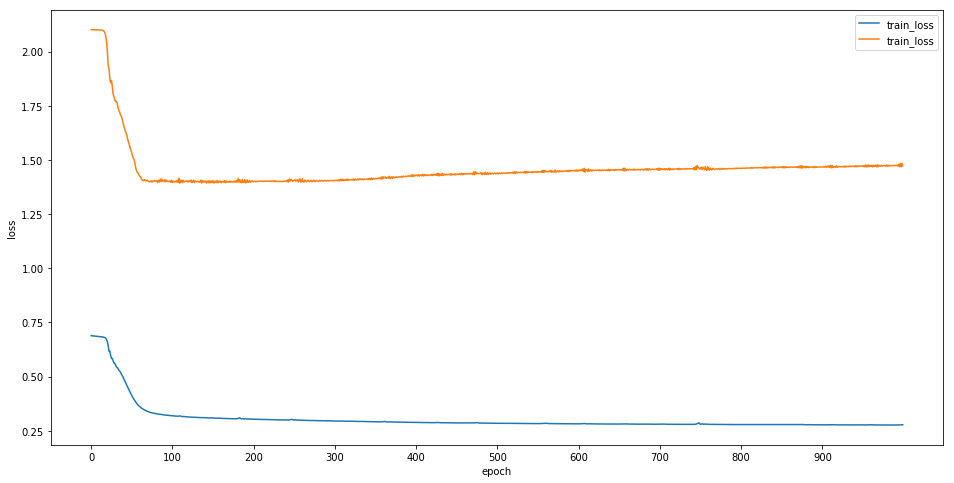

In [263]:
fig = plt.gcf()
fig.set_size_inches(16,8)
plt.plot(range(1000), train_loss, label="train_loss")
plt.plot(range(1000), valid_loss, label="train_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(0, 1000, 100))
plt.legend()
plt.show()

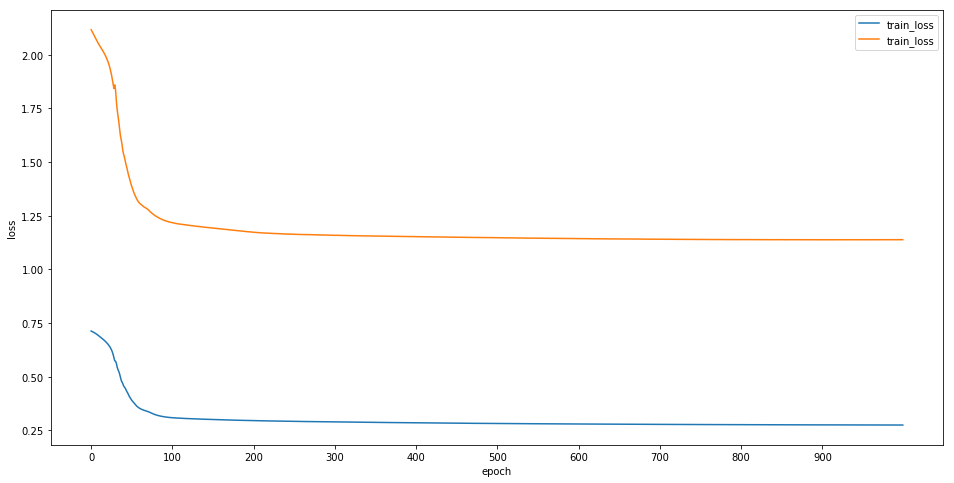

In [266]:
fig = plt.gcf()
fig.set_size_inches(16,8)
plt.plot(range(1000), train_loss, label="train_loss")
plt.plot(range(1000), valid_loss, label="train_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(0, 1000, 100))
plt.legend()
plt.show()

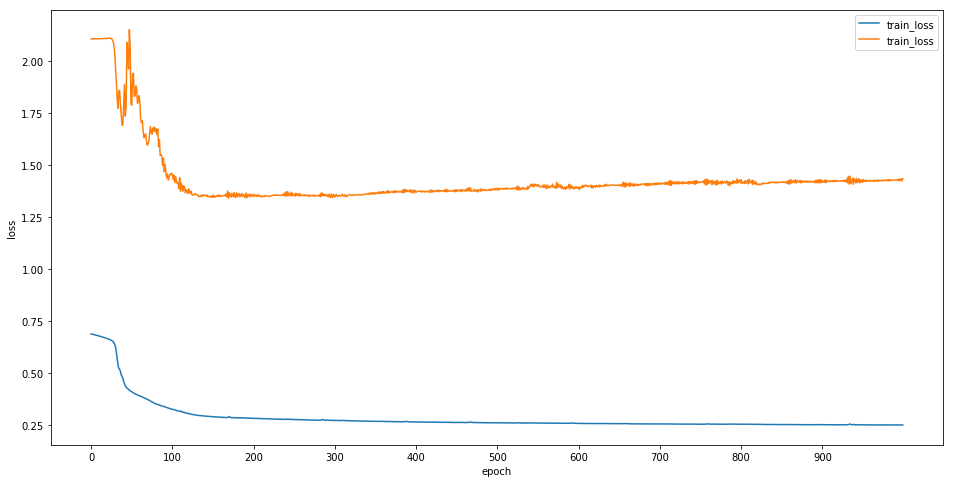

In [269]:
fig = plt.gcf()
fig.set_size_inches(16,8)
plt.plot(range(1000), train_loss, label="train_loss")
plt.plot(range(1000), valid_loss, label="train_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(0, 1000, 100))
plt.legend()
plt.show()